<a href="https://colab.research.google.com/github/n-bzy/iannwtf/blob/main/homework03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use print(ds_info) to answer questions
1. How many training/test images are there? - test = 10000, train = 60000
2. What's the image shape? - shape=28,28,1
3. What range are pixel values in? - 0-255



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the mnist dataset and split it into training and testing data set
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)


def prepare_data_set(data):
    """Prepares the dataset by setting up the data pipeline"""
    # Change the datatype from uint8 to float32
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # Reshape/ flatten the images to a vector
    data = data.map(lambda img, target: (tf.reshape(img, (-1,)), target))
    # Normalize the images values to standart normal
    data = data.map(lambda img, target: (img/128.-1., target))
    # Encode the labels as one-hot-vectors
    data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10))) # Can you get the necessary depth out of ds_info?
    # Cache, shuffle, batch, prefetch data
    data = data.cache()
    data = data.shuffle(1000)
    data = data.batch(100)
    data = data.prefetch(600) # optional: tf.data.AUTOTUNE
    return data

# Prepare the training and test data set
train_dataset = train_ds.apply(prepare_data_set)
test_dataset = test_ds.apply(prepare_data_set)

class MLP(tf.keras.Model):
    """Creates a Class containing a Neuronal Network"""
    def __init__(self):
        """Initializes a Neuronal Network with 2 hidden layers (256 units each) and output layer with 10 units"""
        super(MLP, self).__init__()
        self.layer1 = tf.keras.layers.Dense(256, activation=tf.keras.activations.relu)
        self.layer2 = tf.keras.layers.Dense(256, activation=tf.keras.activations.relu)
        self.layer_out = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)

    @tf.function
    def call(self, input):
        """Pass the input through the Network to create output y"""
        y = self.layer1(input)
        y = self.layer2(y)
        y = self.layer_out(y)
        return y

def training(model, n_epochs, train_data, test_data, loss_f, optimizer_f):
    """Training loop function which contains training and testing of a neuronal
    network model """
    def train(model, train_data, loss_f, optimizer_f):
        """Trains a Neuronal Network model with given data, 
        loss function and optimizer. Returns given output arrays"""
        # Create lists to save accuracy and loss for each data point
        train_accuracy_l = []
        train_loss_l = []

        # Input the dataset through the Network, optimize the parameters
        # and record the loss and accuracy
        for (input, target) in train_data:
            with tf.GradientTape() as tape:
                prediction = model(input)
                s_train_loss = loss_f(target, prediction)
                s_train_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
            gradients = tape.gradient(s_train_loss, model.trainable_variables)
            optimizer_f.apply_gradients(zip(gradients, model.trainable_variables))
            train_accuracy_l.append(np.mean(s_train_accuracy))
            train_loss_l.append(s_train_loss.numpy())

        # Return accuracy and loss
        train_accuracy = tf.reduce_mean(train_accuracy_l)
        train_loss = tf.reduce_mean(train_loss_l)
        return train_accuracy, train_loss
    
    def test(model, test_data, loss_f):
        """Testing a Neuronal Network model with given data and loss function"""

        # Create lists to save accuracy and loss for each data point
        test_accuracy_l = []
        test_loss_l = []

        # Input the dataset through the Network
        # and record the loss and accuracy
        for (input, target) in test_data:
            prediction = model(input)
            sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
            sample_test_loss = loss_f(target, prediction)
            test_accuracy_l.append(np.mean(sample_test_accuracy))
            test_loss_l.append(sample_test_loss.numpy())

        # Return accuracy and loss
        test_accuracy = tf.reduce_mean(test_accuracy_l)
        test_loss = tf.reduce_mean(test_loss_l)
        return test_accuracy, test_loss
    
    # Create lists for training accuracy and loss as well as testing accuracy and loss
    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []

    # Run training and testing data through the network one time before starting to train the network
    # And add results to the lists
    train_accuracy, train_loss = test(model, train_data, loss_f)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    test_accuracy, test_loss = test(model, test_data, loss_f)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    
    # Train and test the network for n Epochs
    for n in range(n_epochs):
        # Training of model
        train_accuracy, train_loss = train(model, train_data, loss_f, optimizer_f)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)

        # Testing of model
        test_accuracy, test_loss = test(model, test_data, loss_f)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)

    return train_accuracies, train_losses, test_accuracies, test_losses

# Hyperparameters
n_epochs = 10
learning_rate = 0.001

# Initialize the model with the MLP class and define loss function and optimizer
model = MLP()
loss_f = tf.keras.losses.CategoricalCrossentropy()
optimizer_f = tf.keras.optimizers.SGD(learning_rate, momentum=0.5)

# Get filled lists out of the training loop function
train_accuracies, train_losses, test_accuracies, test_losses = training(model,n_epochs,train_dataset, test_dataset, loss_f, optimizer_f)


# Visualization

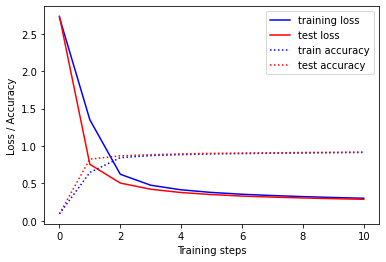

In [ ]:
def visualization(train_losses, train_accuracies, test_losses, test_accuracies):
    """Visualizes accuracy and loss for training and test data using the mean of each epoch.
    Loss is displayed in a regular line, accuracy in a dotted line.
    Training data is displayed in blue, test data in red.
    Parameters
    ----------
    train_losses: numpy.ndarray
        training losses
    train_accuracies: numpy.ndarray
        training accuracies
    test_losses: numpy.ndarray
        test losses
    test_accuracies: numpy.ndarray
        test accuracies
    """

    plt.figure ()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(test_losses, "r-")
    line3, = plt.plot(train_accuracies, "b:")
    line4, = plt.plot(test_accuracies, "r:")
    plt.xlabel("Training steps")
    plt.ylabel("Loss / Accuracy")
    plt.legend((line1 , line2 , line3 , line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()

visualization(train_losses, train_accuracies, test_losses, test_accuracies)

# 3 Adjusting the hyperparameters of your model

1. Learning rate: 0.01 -> 0.001 - less steeper slope of loss, more epochs needed to reach same loss/ accuracy

2. Momentum: 0.0 -> 0.5 - steeper slope of loss, momentum leads to faster reduction of loss

3. batch/ prefetch: (32, 20) -> (100, 600) - reduce computing time from ~10 min to ~2 min

4. Units/ layers: 256 -> 32 - less units in hidden layers lead to less adjusting of the network, therefore higher loss after same epochs




